# MNIST Handwritten Digit Recognition

### Import Libraries
- "torch.nn" for neural network layers (Conv2D, Linear, ... ...)
- "torch.nn.functional" for basic functions (sigmoid, max_pool2d, ... ...)
- "torch.optim" for optimizers (gradient descent)
- "torchvision" for data preparation

In [34]:
# Import libraries
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm

### Load Data
- Utilize "torchvision" to load MNIST handwritten digit data

In [35]:
# Load MNIST dataset
data_path = "data/"
if not os.path.exists(data_path): 
    os.mkdir(data_path)
batch_size_train = 100 # Size of a batch of data for training
batch_size_test = 100 # Size of a batch of data for testing
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_test, shuffle=True)

- Examples from MNIST

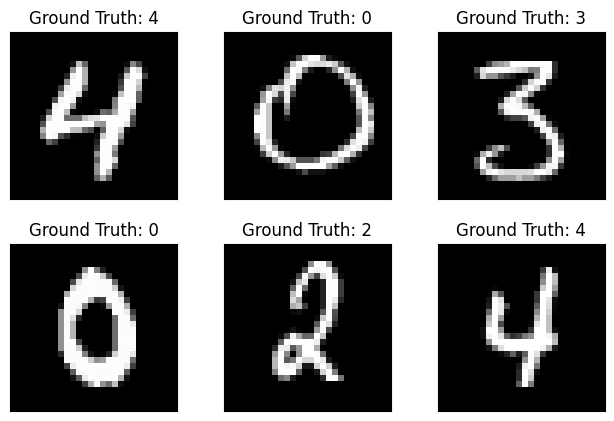

In [36]:
# Show some examples
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

for idx in range(6):
    plt.subplot(2,3,idx+1)
    plt.tight_layout()
    plt.imshow(example_data[idx][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[idx]))
    plt.xticks([])
    plt.yticks([])
plt.show()

### Define the model

- conv1 $\rightarrow$ pooling $\rightarrow$ ReLU $\rightarrow$ conv2 $\rightarrow$ pooling $\rightarrow$ ReLU $\rightarrow$ fc1 $\rightarrow$ ReLU $\rightarrow$ fc2  

In [37]:
# Define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320) # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Instantiate the Model

- *network* is the model
- *optimizer* is for gradient descent
- Gradients are derived automatically

In [38]:
learning_rate = 0.01
# Instantiate the model
network = Net()
# Instantiate the optimizer
optimizer = optim.SGD(network.parameters(), lr=learning_rate)


### Training and Testing

- Epoch: a pass of training of **the dataset**
- Step: an iteration of gradient descent on **a batch of data**

```python
for epoch in range(n_epochs): 
    # Training
    for step, (data, target) in enumerate(train_loader):
        # A training step
    # Testing
    for step, (data, target) in enumerate(test_loader):
        # A testing step
```

### A Training Step

- *output* is the inferred results
- *loss* is the loss value
- *loss.backward()* computes the gradients
- *optimizer.step()* do gradient descent

```python
        # Inference
        output = network(data)
        # Compute the loss
        loss = F.cross_entropy(output, target)
        # Gradient descent
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
```

### A Testing Step

- *F.cross_entropy* computes the loss
- *pred* is the prediction (the class with the maximum probability)
- *(pred == target).sum()* computes the accuracy

```python
        # Inference
        output = network(data)
        # Compute the loss
        test_loss += F.cross_entropy(output, target).item()
        # Get the prediction
        pred = output.max(dim=1)[1]
        # Count correct predictions
        correct += (pred == target).sum()
```

In [39]:
test_losses = []
accuracies = []
n_epochs = 10
for epoch in range(n_epochs): 
    # Training
    network.train()
    progress = tqdm(train_loader)
    for step, (data, target) in enumerate(progress):
        # Inference
        output = network(data)
        # Compute the loss
        loss = F.cross_entropy(output, target)
        # Gradient descent
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log the result
        progress.set_postfix(loss=loss.item())
    # Testing
    test_loss = 0
    accuracy = 0
    correct = 0
    count = 0
    network.eval()
    progress = tqdm(test_loader)
    for step, (data, target) in enumerate(progress):
        with torch.no_grad():
            # Inference
            output = network(data)
            # Compute the loss
            test_loss += F.cross_entropy(output, target).item()
            # Get the prediction
            pred = output.max(dim=1)[1]
            # Count correct predictions
            correct += (pred == target).sum()
            count += target.shape[0]
        # Log the result
        progress.set_postfix(loss=loss.item(), accu=(correct/count).item())
        test_loss /= len(test_loader.dataset)
        accuracy = correct/count
        test_losses.append(test_loss)
        accuracies.append(accuracy)
    print(f"[Epoch {epoch}]: loss={test_loss}, accuracy={accuracy}")

100%|██████████| 100/100 [00:02<00:00, 40.00it/s, accu=0.905, loss=0.377]


[Epoch 0]: loss=3.053067903857245e-05, accuracy=0.9053999781608582


100%|██████████| 100/100 [00:02<00:00, 41.54it/s, accu=0.951, loss=0.109]


[Epoch 1]: loss=2.1132782719706527e-05, accuracy=0.9510999917984009


100%|██████████| 100/100 [00:02<00:00, 38.76it/s, accu=0.961, loss=0.0777]


[Epoch 2]: loss=5.594836872786197e-06, accuracy=0.9606999754905701


100%|██████████| 100/100 [00:02<00:00, 42.55it/s, accu=0.969, loss=0.145]


[Epoch 3]: loss=7.462659485776159e-06, accuracy=0.9686999917030334


100%|██████████| 100/100 [00:02<00:00, 36.95it/s, accu=0.975, loss=0.121]


[Epoch 4]: loss=1.4698523440803799e-05, accuracy=0.9746999740600586


100%|██████████| 100/100 [00:02<00:00, 42.53it/s, accu=0.977, loss=0.122]


[Epoch 5]: loss=5.903642612277747e-06, accuracy=0.9768999814987183


100%|██████████| 100/100 [00:02<00:00, 43.95it/s, accu=0.98, loss=0.0588]


[Epoch 6]: loss=4.03867803011182e-06, accuracy=0.9800999760627747


100%|██████████| 100/100 [00:02<00:00, 43.15it/s, accu=0.981, loss=0.0833]


[Epoch 7]: loss=2.6937958960783373e-06, accuracy=0.9814000129699707


100%|██████████| 100/100 [00:02<00:00, 43.46it/s, accu=0.982, loss=0.0408]


[Epoch 8]: loss=4.852577212195942e-06, accuracy=0.9818999767303467


100%|██████████| 100/100 [00:02<00:00, 42.79it/s, accu=0.983, loss=0.0264]

[Epoch 9]: loss=7.311228955848994e-06, accuracy=0.983299970626831


In [40]:
# Compare with traditional machine learning
torchvision.datasets.MNIST('data/', download=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train